## **Import Libraries**

In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import yaml
from pathlib import Path

## **Load configs**

In [ ]:
project_root = Path.cwd().parent  
config_path = project_root / "config" / "config.yaml"
CFG = yaml.safe_load(open(config_path))
RAW = project_root / CFG["paths"]["data_raw"]
SEP = CFG.get("io", {}).get("csv_sep", ",")


## **Read data**

In [8]:
assert RAW.exists(), f"Missing file {RAW}"

df = pd.read_csv(RAW, sep=SEP)
print(df.shape)

(1599, 12)


## **Contract check (required columns)**

In [9]:
SCHEMA = yaml.safe_load(open(project_root /"schema.yaml"))
required = set(SCHEMA.get("required", [])) | {SCHEMA.get("target", "quality")}
missing = required - set(df.columns)
print(missing)

set()


## **Target Histogram**

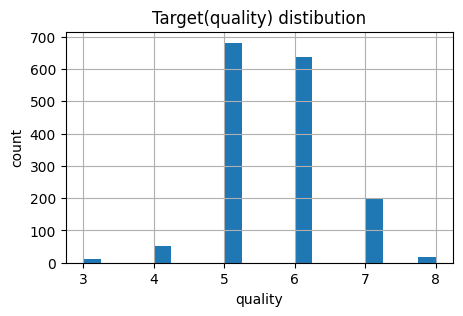

In [ ]:
TARGET = SCHEMA.get("target", "quality") # Calling the target variable
plt.figure(figsize = (5,3))
df[TARGET].hist(bins=20)
plt.title("Target(quality) distibution")
plt.xlabel(TARGET)
plt.ylabel("count")
Path(project_root / "artifacts/research").mkdir(parents=True, exist_ok=True)
plt.savefig(project_root /"artifacts/research/target_hist.png", dpi=150, bbox_inches="tight")

- From the histogram, I can see most wine samples are rated 5 or 6—right in the middle of the scale. Ratings of 3, 4, 7, and 8 are much less common, which shows the dataset is imbalanced. This imbalance could skew model predictions toward the majority classes. So when training and evaluating models, I’ll need to consider techniques to handle class imbalance.

## **Correlation heatmap (numeric only)**

quality                1.000000
alcohol                0.476166
sulphates              0.251397
citric acid            0.226373
fixed acidity          0.124052
residual sugar         0.013732
free sulfur dioxide   -0.050656
pH                    -0.057731
chlorides             -0.128907
density               -0.174919
Name: quality, dtype: float64

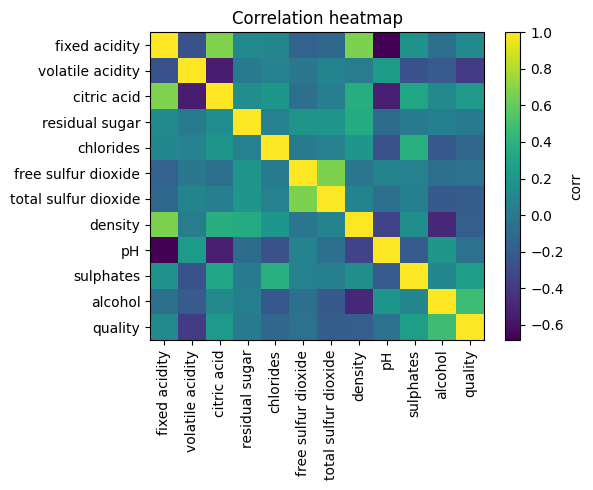

In [23]:
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(6,5))
plt.imshow(corr, cmap= "viridis", aspect= "auto")
plt.xticks(range(len(num_cols)), list(num_cols), rotation= 90)
plt.yticks(range(len(num_cols)), list(num_cols))
plt.colorbar(label="corr")
plt.title("Correlation heatmap")
plt.tight_layout()
plt.savefig(project_root/"artifacts/research/corr_heatmap.png", dpi=150, bbox_inches="tight")
corr[TARGET].sort_values(ascending=False).head(10)


- From the correlation matrix, I found alcohol has the strongest positive link to wine quality (0.48), making it the most predictive feature. Sulphates and citric acid also show moderate positive correlations.

- Fixed acidity is weakly correlated, while residual sugar has almost no impact. Density and chlorides have the strongest negative correlations, meaning higher values tend to lower quality.

## **Features vs Target (scatter)**

['alcohol', 'volatile acidity', 'sulphates']

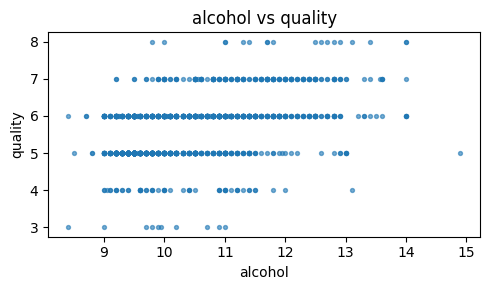

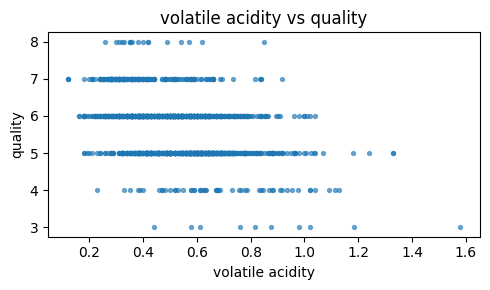

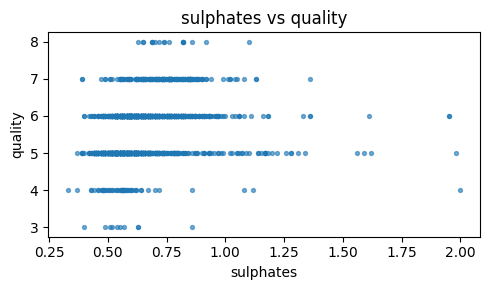

In [25]:
top3 = corr[TARGET].drop(labels=[TARGET]).abs().sort_values(ascending=False).head(3).index.tolist()
for col in top3:
    plt.figure(figsize=(5,3))
    plt.scatter(df[col], df[TARGET], s=8, alpha=0.6)
    plt.xlabel(col); plt.ylabel(TARGET)
    plt.title(f"{col} vs {TARGET}")
    plt.tight_layout()
    plt.savefig(project_root/f"artifacts/research/scatter_{col}_vs_{TARGET}.png", dpi=150, bbox_inches="tight")
top3


- I plotted the top 3 features against wine quality to see how they relate. Alcohol shows a clear upward trend, higher alcohol usually means better quality. Sulphates have a moderate positive pattern, while citric acid shows a weaker link.

## **Quick Facts**

In [26]:
desc = df[num_cols].describe().T
facts = {
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "target_min_max": (float(df[TARGET].min()), float(df[TARGET].max())),
    "duplicates": int(df.duplicated().sum()),
    "top3_corr_feats": top3,
}
report_path = Path(project_root/"artifacts/research/eda_report.md")
report_path.write_text(
    f"- rows: {facts['n_rows']}\n"
    f"- cols: {facts['n_cols']}\n"
    f"- target min/max: {facts['target_min_max']}\n"
    f"- duplicate rows: {facts['duplicates']}\n"
    f"- top-3 features by |corr|: {facts['top3_corr_feats']}\n"
)
report_path.as_posix()


'd:/MLops/wine-ml-pipeline/artifacts/research/eda_report.md'